In [ ]:
import requests
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
data = []
for i in range(1, 121):
    url = f"https://world.openfoodfacts.org/api/v2/search?categories=chocolates&fields=code,product_name,brands,nutriments&page_size=100&page={i}"
    response = requests.get(url)
    data1 = response.json()
    data.extend(data1['products'])

In [ ]:
data= pd.DataFrame(data)

In [ ]:
data.info()

In [ ]:
data.isnull().sum()

In [ ]:
data.apply(lambda x: x=='').sum()

In [ ]:
data.apply(lambda x: x=={}).sum()

In [ ]:
t1=data[data['nutriments'].apply(lambda x: x=={})]
data=data.drop(t1.index)

In [ ]:
data=data.replace('',np.nan)

In [ ]:
def is_empty(x):
    return (x == {}) or (x == "") or (pd.isna(x))
    
empty_counts = data.map(is_empty).sum(axis=1)
empty=empty_counts[empty_counts.apply(lambda x: x>1)]
empty_counts

In [ ]:
filtered_data=data.drop(empty.index)

In [ ]:
filtered_data.isnull().sum()

In [ ]:
filtered_data.apply(lambda x: x=='').sum()

In [ ]:
filtered_data.apply(lambda x: x=={}).sum()

In [ ]:
filtered_data[filtered_data['brands'].isnull()]

In [ ]:
filtered_data['brands']=filtered_data['brands'].fillna('Unbranded')
filtered_data['product_name']=filtered_data['product_name'].fillna('Generic Chocolate')

In [ ]:
filtered_data.isnull().sum()

In [ ]:
dict_data=filtered_data.to_dict(orient='records')
dict_data

In [ ]:
product_info=[]
nutrient_info=[]
derived_metrics=[]
for i in dict_data:
    n= i.get('nutriments')
    product_info.append(dict(
        product_code=i['code'],
        product_name=i.get('product_name'),
        brand=i.get('brands')
    ))
    nutrient_info.append(dict(
        product_code=i['code'],
        energy_kcal_value=n.get('energy-kcal_value'),
        energy_kj_value=n.get('energy-kj_value'),
        carbohydrates_value=n.get('carbohydrates_value'),
        sugars_value=n.get('sugars_value'),
        fat_value=n.get('fat_value'),
        saturated_fat_value=n.get('saturated-fat_value'),
        proteins_value=n.get('proteins_value'),
        fiber_value=n.get('fiber_value'),
        salt_value=n.get('salt_value'),
        sodium_value=n.get('sodium_value'),
        fruits_vegetables_nuts_estimate_from_ingredients_100g=n.get('fruits-vegetables-nuts-estimate-from-ingredients_100g'),
        nutrition_score_fr=n.get('nutrition-score-fr'),
        nova_group=n.get('nova-group')
    ))
    
    energy_kcal_value=n.get('energy-kcal_value',1)
    sugars_value=n.get('sugars_value',1)
    proteins_value=n.get('proteins_value',1)
    nutrition_score_fr=n.get('nutrition-score-fr',0)
    nova_group=n.get('nova-group')
    s_to_c_r=0
    if sugars_value is not None and energy_kcal_value is not None:
        if sugars_value!=0 and energy_kcal_value!=0:
            s_to_c_r= sugars_value / energy_kcal_value
    
    if energy_kcal_value >=400:
        calorie_category='high'
    elif energy_kcal_value >=250:
        calorie_category='medium'
    elif energy_kcal_value >=0:
        calorie_category='low'
    if sugars_value >=22.5:
        sugar_category='high'
    elif sugars_value >=5.0:
        sugar_category='medium'
    elif sugars_value >=0:
        sugar_category='low' 
    if proteins_value >10:
        protein_category='high'
    elif proteins_value >=3:
        protein_category='medium'
    elif proteins_value < 3:
        protein_category='low'
    if nova_group == 4:
        is_ultra_processed='yes'
    else:
        is_ultra_processed='no'
    if nutrition_score_fr <=-1:
        health_category='best'
    elif nutrition_score_fr <=2:
        health_category='better'
    elif nutrition_score_fr <=10:
        health_category='good'
    elif nutrition_score_fr <=18:
        health_category='bad'
    elif nutrition_score_fr >18:
        health_category='worst'
    derived_metrics.append(dict(
        product_code=i['code'],
        sugar_to_carb_ratio=s_to_c_r,
        calorie_category=calorie_category,
        sugar_category=sugar_category,
        protein_category=protein_category,
        health_category=health_category,
        is_ultra_processed=is_ultra_processed
    ))

product_info=pd.DataFrame(product_info)
nutrient_info=pd.DataFrame(nutrient_info)
derived_metrics=pd.DataFrame(derived_metrics)

In [ ]:
nutrient_info['energy_kcal_value']= nutrient_info['energy_kcal_value'].fillna(nutrient_info['energy_kj_value']/ 4.184)
nutrient_info['energy_kj_value']= nutrient_info['energy_kj_value'].fillna(nutrient_info['energy_kcal_value']* 4.184)
nutrient_info['sodium_value']= nutrient_info['sodium_value'].fillna(nutrient_info['salt_value']/ 2.5)
nutrient_info['salt_value']= nutrient_info['salt_value'].fillna(nutrient_info['sodium_value']* 2.5)

In [ ]:
nutrient_info=nutrient_info.fillna(nutrient_info.median(numeric_only=True))

In [52]:
conn= sqlite3.connect(r"D:\Guvi\ChocoCrunch Analysis Project\Choco_Analysis.db")
cursor=conn.cursor()

cursor.execute("""
CREATE TABLE product_info(
    product_code TEXT PRIMARY KEY,
    product_name TEXT,
    brand TEXT
)""")
cursor.execute("""
CREATE TABLE nutrient_info(
    product_code TEXT,
    energy_kcal_value FLOAT,
    energy_kj_value FLOAT,
    carbohydrates_value FLOAT,
    sugars_value FLOAT,
    fat_value FLOAT,
    saturated_fat_value FLOAT,
    proteins_value FLOAT,
    fiber_value FLOAT,
    salt_value FLOAT,
    sodium_value FLOAT,
    fruits_vegetables_nuts_estimate_from_ingredients_100g FLOAT,
    nutrition_score_fr INTEGER,
    nova_group INTEGER,
    FOREIGN KEY(product_code) REFERENCES product_info(product_code)
)""")
cursor.execute("""
CREATE TABLE derived_metrics(
    product_code TEXT,
    sugar_to_carb_ratio FLOAT,
    calorie_category TEXT,
    sugar_category TEXT,
    is_ultra_processed TEXT,
    protein_category TEXT,
    health_category TEXT,
    FOREIGN KEY(product_code) REFERENCES product_info(product_code)
)""")

product_info.to_sql('product_info', conn, if_exists='append', index=False)
nutrient_info.to_sql('nutrient_info', conn, if_exists='append', index=False)
derived_metrics.to_sql('derived_metrics', conn, if_exists='append', index=False)
conn.close()

In [ ]:
qureies={
    "Count products per brand":
        "SELECT brand, COUNT(*) as product_count FROM product_info GROUP BY brand;",
    "Count unique products per brand":
        "SELECT brand, product_name, COUNT(product_name) as product_count FROM product_info GROUP BY product_name;",
    "Top 5 brands by product count":
        "SELECT brand, COUNT(product_name) as product_count FROM product_info GROUP BY brand ORDER BY product_count DESC LIMIT 5;",
    "Products with missing product name":
        "SELECT * FROM product_info WHERE product_name='';",
    "Number of unique brands":
        "SELECT COUNT(DISTINCT brand) as unique_brands_count FROM product_info;",
    "Products with code starting with '3'":
        "SELECT * FROM product_info WHERE product_code LIKE '3%';",
    "Top 10 products with highest energy-kcal_value":
        "SELECT * FROM nutrient_info ORDER BY energy_kcal_value DESC LIMIT 10;",
    "Average sugars_value per nova-group":
        "SELECT nova_group, AVG(sugars_value) as avg_sugar_value FROM nutrient_info GROUP BY nova_group;",
    "Count products with fat_value > 20g":
        "SELECT COUNT(*) as fat_value_morethan_20 FROM nutrient_info WHERE fat_value > 20.0;",
    "Average carbohydrates_value per product":
        "SELECT product_code, AVG(carbohydrates_value) as avg_carbohydrates_value FROM nutrient_info;",
    "Products with sodium_value > 1g":
        "SELECT * FROM nutrient_info WHERE sodium_value > 1g;",
    "Count products with non-zero fruits-vegetables-nuts content":
        "SELECT COUNT(*) as non_zero_fruits_vegetables_nuts_count FROM nutrient_info WHERE fruits_vegetables_nuts_estimate_from_ingredients_100g > 0;",
    "Products with energy-kcal_value > 500":
        "SELECT * FROM nutrient_info WHERE energy_kcal_value > 500;",
    "Count products per calorie_category":
        "SELECT calorie_category, COUNT(*) as product_count FROM derived_metrics GROUP BY calorie_category;",
    "Count of High Sugar products":
        "SELECT COUNT(*) as high_sugar_count FROM derived_metrics WHERE sugar_category = 'high';",
    "Average sugar_to_carb_ratio for High Calorie products":
        "SELECT AVG(sugar_to_carb_ratio) as high_calorie_avg_sugartocard_ratio FROM derived_metrics WHERE calorie_category = 'high';",
    "Products that are both High Calorie and High Sugar":
        "SELECT * FROM derived_metrics WHERE calorie_category = 'high' AND sugar_category = 'high'",
    "Number of products marked as ultra-processed":
        "SELECT COUNT(*) FROM derived_metrics WHERE is_ultra_processed = 'yes';",
    "Products with sugar_to_carb_ratio > 0.7":
        "SELECT * FROM derived_metrics WHERE sugar_to_carb_ratio > 0.7;",
    "Average sugar_to_carb_ratio per calorie_category":
        "SELECT calorie_category, AVG(sugar_to_carb_ratio) as avg_sugar_to_card_ratio FROM derived_metrics GROUP BY calorie_category;",
    "Top 5 brands with most High Calorie products":
        """SELECT p.brand 
        FROM product_info p JOIN derived_metrics d ON p.product_code = d.product_code 
        WHERE calorie_category = 'high' 
        ORDER BY p.brand DESC LIMIT 5;""",
    "Average energy-kcal_value for each calorie_category":
        """SELECT d.calorie_category, AVG(n.energy-kcal_value) as avg_energy_kcal_value 
        FROM nutrient_info n JOIN derived_metrics d ON n.product_code = d.product_code
        GROUP BY d.calorie_category;""",
    "Count of ultra-processed products per brand":
        """SELECT p.brand, COUNT(d.is_ultra_processed) as count_of_ultra_processed_products
        FROM product_info p JOIN derived_metrics d ON p.product_code = d.product_code
        WHERE d.is_ultra_processed = 'yes';""",
    "Products with High Sugar and High Calorie along with brand":
        """SELECT d.*, p.brand
        FROM product_info p JOIN derived_metrics d ON p.product_code = d.product_code
        WHERE d.sugar_category = 'high' AND d.calorie_category = 'high';""",
    "Average sugar content per brand for ultra-processed products":
        """SELECT p.brand, AVG(n.sugars_value)
        FROM product_info p JOIN nutrient_info n ON p.product_code = n.product_code JOIN derived_metrics d ON p.product_code = d.product_code
        WHERE d.is_ultra_processed = 'yes';""",
    "Number of products with fruits/vegetables/nuts content in each calorie_category":
        """SELECT d.calorie_category, n.fruits-vegetables-nuts-estimate-from-ingredients_100g, COUNT(*)
        FROM nutrient_info n JOIN derived_metrics d ON n.product_code = d.product_code
        GROUP BY n.fruits-vegetables-nuts-estimate-from-ingredients_100g;""",
    "Top 5 products by sugar_to_carb_ratio with their calorie and sugar category":
        """SELECT p.*, d.calorie_category, d.sugar_category
        FROM product_info p JOIN derived_metrics d ON p.product_code = d.product_code
        ORDER BY d.sugar_to_carb_ratio DESC LIMIT 5;""",
}

In [ ]:
import sqlite3
conn= sqlite3.connect(r"D:\Guvi\ChocoCrunch Analysis Project\Choco_Analysis.db")
cursor=conn.cursor()
dsql=list(qureies.values())[3]
read=pd.read_sql(dsql,conn)
conn.close()
read

In [ ]:
product_info.info()

In [ ]:
nutrient_info.describe()

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(filtered_data.isnull())
plt.title("Heatmap of Dataset's Null")

In [ ]:
merged = (product_info.merge(nutrient_info, on="product_code", how="inner").merge(derived_metrics, on="product_code", how="inner"))

calorie_count= merged['calorie_category'].value_counts()

plt.figure(figsize=(8,5))
calorie_count.plot(kind='bar',stacked='false')
plt.title("Number of products in each calorie category")
plt.xlabel("Calorie Category")
plt.ylabel("Numbeer of Products")

Text(0.5, 1.0, 'Distrubution of Products by Nova-groups')

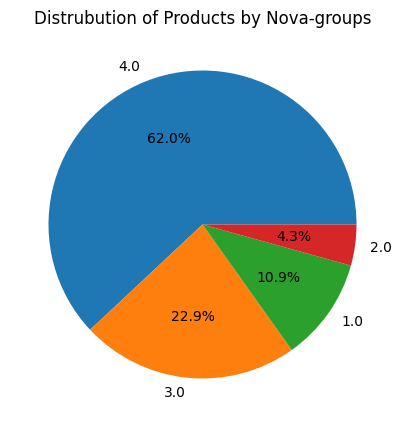

In [162]:
counts= merged['nova_group'].value_counts()

plt.figure(figsize=(8,5))
plt.pie(counts,labels=counts.index,autopct='%1.1f%%')
plt.title("Distrubution of Products by Nova-groups")

Text(0.5, 1.0, 'Calorie vs Sugar contents')

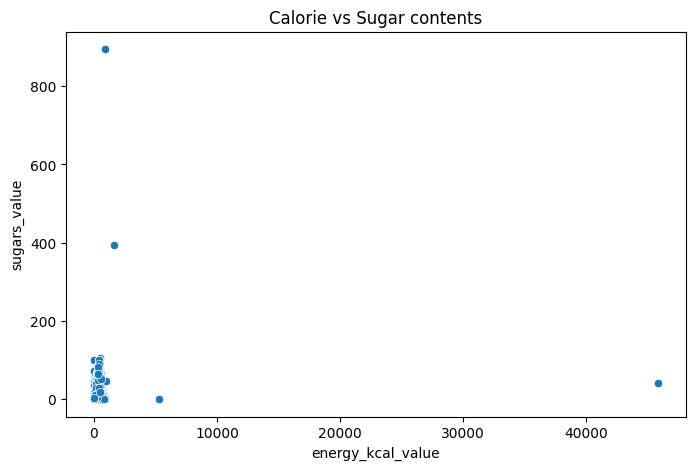

In [163]:
plt.figure(figsize=(8,5))
sns.scatterplot(data= merged,x='energy_kcal_value',y='sugars_value')
plt.title('Calorie vs Sugar contents')

In [225]:
d=merged['proteins_value'].value_counts()
loc=d.iloc[1:15]
new=merged[merged['proteins_value'].isin(loc.index)]

Text(0.5, 0.98, 'Distributions of Key Nutritional Variables')

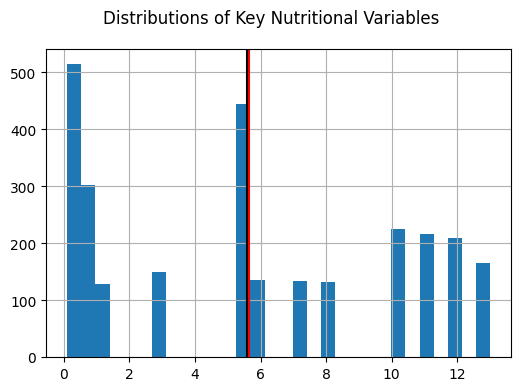

In [230]:
new['proteins_value'].hist(bins=30, figsize=(6,4))
plt.axvline((new['proteins_value'].mean()),color='red',label=f"Average:{np.round(new['proteins_value'].mean(),2)}")
plt.axvline((new['proteins_value'].median()),color='black',label="Median Bill")
plt.suptitle("Distributions of Key Nutritional Variables")

Text(0.5, 1.0, 'Sugar to Carb Ratio Distributed by Brands')

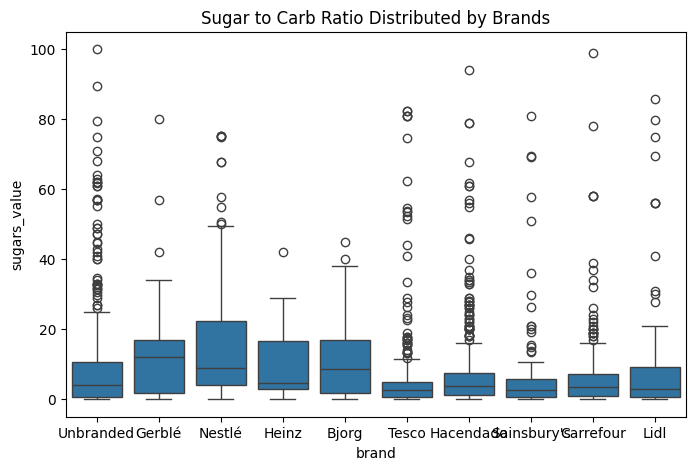

In [198]:
top_brands = merged["brand"].value_counts().nlargest(10).index
plt.figure(figsize=(8,5))
sns.boxplot(x="brand", y="sugars_value", data=merged[merged["brand"].isin(top_brands)])
plt.title("Sugar to Carb Ratio Distributed by Brands")

Text(0.5, 1.0, 'Correlation of Calorie-Sugar-Fat')

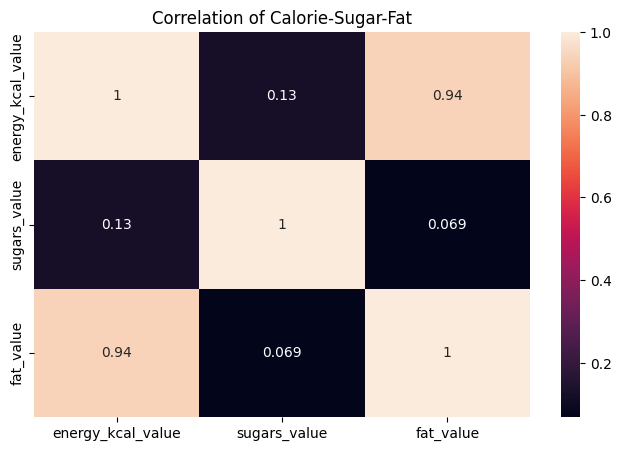

In [168]:
corr= merged[['energy_kcal_value','sugars_value','fat_value']].corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True)
plt.title('Correlation of Calorie-Sugar-Fat')

Text(0.5, 1.0, 'title')

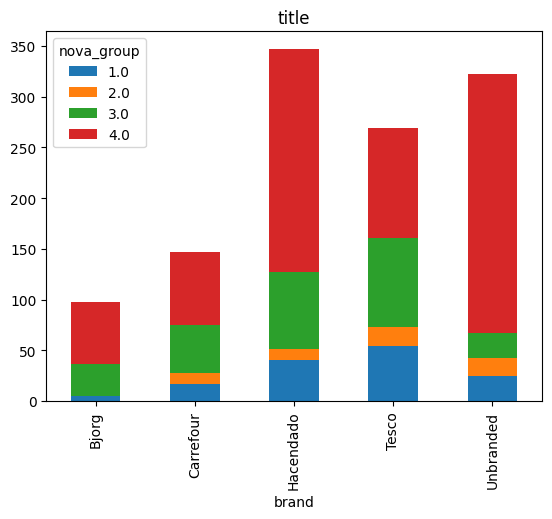

In [176]:
top=merged['brand'].value_counts().nlargest(5).index
filtered=merged[merged['brand'].isin(top)]

pd.crosstab(filtered['brand'],filtered['nova_group']).plot(kind='bar',stacked=True)
plt.title('title')

In [158]:
avg_calories = merges['energy_kcal_value'].mean()
avg_sugars = merges['sugars_value'].mean()
ultra_count = merges[merges['nova_group']==1].shape[0]

print(f"🔥 KPI Dashboard 🔥")
print(f"Average Calories: {avg_calories:.2f} kcal")
print(f"Average Sugars: {avg_sugars:.2f} g")
print(f"Ultra-Processed Products: {ultra_count}")


🔥 KPI Dashboard 🔥
Average Calories: 278.32 kcal
Average Sugars: 11.06 g
Ultra-Processed Products: 1258


In [ ]:
merged.to_csv("Final.csv", index=False)